In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

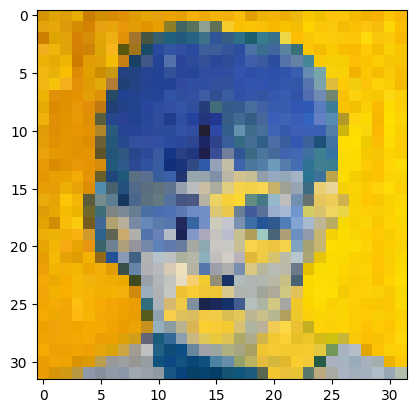

In [7]:
# load an image and resive to 32x32

image_path = 'wechatAvatars/106毛瀚燚-信科20.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (32, 32))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [13]:
# 对wechatAvatars里的所有图片进行处理
# resize成64x64
# 存储到新的文件夹里

import os

save_dir = 'images64x64'
os.makedirs(save_dir, exist_ok=True)

for file in os.listdir('wechatAvatars'):
    image_path = os.path.join('wechatAvatars', file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))

    save_path = os.path.join(save_dir, file)
    cv2.imwrite(save_path, image)


/Users/harrym/miniconda3/envs/dip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


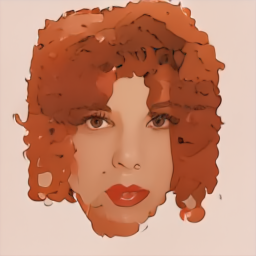

In [2]:
import torch
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('dlcvproj/ddpm-celebahq-finetuned-cartoonfaces')

pipe = pipeline.to("mps")

# Recommended if your computer has < 64 GB of RAM
pipe.enable_attention_slicing()


image = pipeline().images[0]
image

In [1]:
import os
import shutil

# 读取 male_num.txt 文件并将其转换为一个列表
with open('male_num.txt', 'r') as file:
    male_num = [int(num) for line in file for num in line.split()]

# 确保目标文件夹存在
os.makedirs('images_male', exist_ok=True)
os.makedirs('images_female', exist_ok=True)

# 遍历 images 文件夹中的所有文件
for filename in os.listdir('images'):
    # 检查文件名是否以数字开头
    if filename.split('_')[0].isdigit():
        # 提取文件名前缀序号
        file_num = int(filename.split('_')[0])
        if file_num > 20000:
            continue
        # 如果序号在 male_num 列表中，则移动文件
        if file_num in male_num:
            shutil.move(os.path.join('images', filename), os.path.join('images_male', filename))
        else:
            shutil.move(os.path.join('images', filename), os.path.join('images_female', filename))


In [3]:
# 统计images_male和images_female文件夹中的文件数量
print(len(os.listdir('images_female')))

18622


In [5]:
# 从images_female里随机选取5000张照片移动至image_female_less
import random

# 采样5000个序号小于18622
random.seed(0)
sampled_files = random.sample(range(18622), 5000)

for i, filename in enumerate(os.listdir('images_female')):
    if i in sampled_files:
        shutil.move(os.path.join('images_female', filename), os.path.join('images_female_less', filename))

In [84]:
# training configuration

from dataclasses import dataclass

@dataclass
class TrainingConfig:
    date = 240602_1
    image_size = 64  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    # config for classifier-free diffusion guidance
    drop_prob = 0.2  # drop probability for classifier-free diffusion
    guide_weight = 2
    #
    save_image_epochs = 10
    save_model_epochs = 25
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = f"experiments/{date}/"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    # hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    # hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    num_class_embeds = 3  # 0 female, 1 for male, 2 for None (None when dropped)
    seed = 0


config = TrainingConfig()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./images")

Generating train split: 6203 examples [00:00, 54668.92 examples/s]


In [72]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [int(label) for label in examples["label"]]
    return {"images": images, "labels": labels}


dataset.set_transform(transform)

/var/folders/x8/_gfytq7j58s7ls22f1c9rczc0000gn/T/ipykernel_17279/2405353314.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


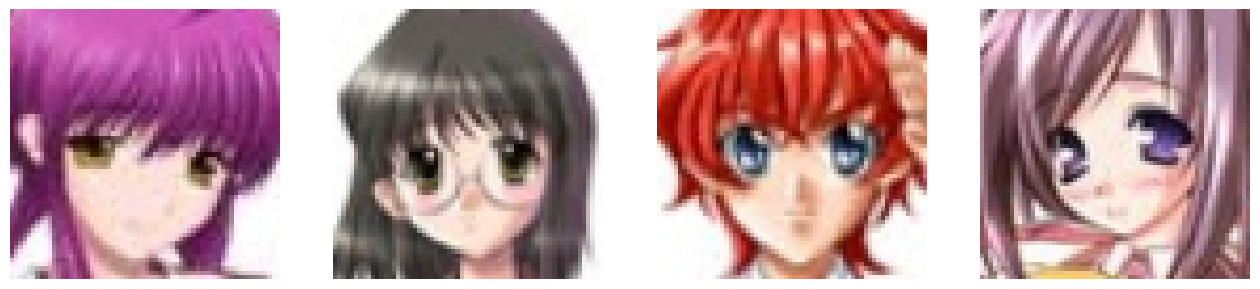

In [77]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][0:4]['images']):
    
    img = image.permute(1, 2, 0).cpu().numpy()
    axs[i].imshow(img)
    axs[i].set_axis_off()
fig.show()

In [75]:
import torch
import torch.nn.functional as F

train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=config.train_batch_size, shuffle=True)

In [76]:
for batch in train_dataloader:
    print(batch)
    images = batch['images']
    labels = batch['labels']
    print(images.shape)
    print(labels)
    break

{'images': tensor([[[[1.0000, 1.0000, 0.9961,  ..., 0.9882, 1.0000, 1.0000],
          [0.9961, 1.0000, 0.9961,  ..., 0.9843, 0.9922, 1.0000],
          [0.9961, 1.0000, 1.0000,  ..., 0.9843, 0.9961, 1.0000],
          ...,
          [0.2314, 0.2000, 0.0314,  ..., 0.1333, 0.0157, 0.0235],
          [0.2588, 0.1490, 0.0118,  ..., 0.1451, 0.0078, 0.0235],
          [0.2706, 0.1020, 0.0000,  ..., 0.1412, 0.0039, 0.0314]],

         [[1.0000, 0.9961, 0.9922,  ..., 1.0000, 0.9961, 0.9922],
          [1.0000, 0.9922, 0.9922,  ..., 1.0000, 0.9961, 0.9922],
          [1.0000, 0.9922, 0.9922,  ..., 0.9961, 1.0000, 0.9922],
          ...,
          [0.4549, 0.4667, 0.2235,  ..., 0.2902, 0.1569, 0.2549],
          [0.5059, 0.4118, 0.1765,  ..., 0.3059, 0.1412, 0.2431],
          [0.5216, 0.3490, 0.1412,  ..., 0.3059, 0.1333, 0.2314]],

         [[1.0000, 0.9961, 0.9882,  ..., 0.9765, 0.9922, 1.0000],
          [1.0000, 0.9961, 0.9882,  ..., 0.9804, 0.9922, 1.0000],
          [1.0000, 1.0000, 0.99

In [82]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=config.num_class_embeds,  # the dimension of the class token
)

model = model.to(device)

In [78]:
sample_image = dataset['train'][0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0, class_labels=torch.tensor([1])).sample.shape)

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])


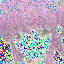

In [47]:
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [49]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [52]:
from diffusers import DDPMPipeline, DDIMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline.sample(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [86]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            labels = batch["labels"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # # Predict the noise residual
                # noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                # loss = F.mse_loss(noise_pred, noise)

                # Classifier-free guidance
                # drop the label (set it to 2) with probability `config.drop_prob`
                mask = torch.rand(bs, device=clean_images.device) > config.drop_prob
                labels = labels * mask.long() + 2 * ~mask.long()
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [87]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on MPS.


/Users/harrym/miniconda3/envs/dip/lib/python3.11/site-packages/accelerate/accelerator.py:401: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


ValueError: fp16 mixed precision requires a GPU (not 'mps').

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])